In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')  # mount your Google Drive

# Example: if your dataset is in drive/MyDrive/dataset.zip
zip_path = '/content/drive/MyDrive/dance_data.zip'  # adjust this path if needed

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dance_data')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten,Dense,Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder

In [4]:
# Load train and test csv file for image class
train = pd.read_csv('/content/dance_data/dataset/train.csv')
test = pd.read_csv('/content/dance_data/dataset/test.csv')

print(train.head())
print(test.head())
print(train['target'].value_counts())

     Image         target
0   96.jpg       manipuri
1  163.jpg  bharatanatyam
2  450.jpg         odissi
3  219.jpg      kathakali
4  455.jpg         odissi
     Image
0  508.jpg
1  246.jpg
2  473.jpg
3  485.jpg
4  128.jpg
target
mohiniyattam     50
odissi           49
kathakali        47
bharatanatyam    47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: count, dtype: int64


In [5]:
train.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


<Axes: xlabel='target'>

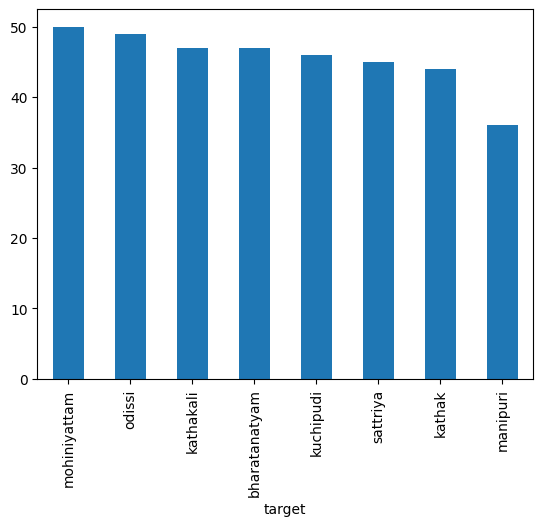

In [6]:
#Histogram chart for target
train['target'].value_counts().plot(kind='bar')

In [8]:
base='/content/dance_data/dataset'
train_dir = os.path.join(str(base)+ '/train/')
test_dir = os.path.join(str(base)+'/test/')

train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

print(train_fnames[:9])
print(test_fnames[:9])


['355.jpg', '36.jpg', '243.jpg', '79.jpg', '204.jpg', '74.jpg', '63.jpg', '257.jpg', '466.jpg']
['324.jpg', '224.jpg', '508.jpg', '458.jpg', '226.jpg', '470.jpg', '23.jpg', '484.jpg', '162.jpg']


In [9]:
# Images might be in different size. In this section I assigning all image at same size of 224*224
img_width = 224
img_height = 224

In [10]:
# this function reads image from the disk,train file for image and class maping and returning output in numpy array formate
# for input and target data
def train_data_preparation(list_of_images, train, train_dir):
    """
    Returns two arrays:
        train_data is an array of resized images
        train_label is an array of labels
    """
    train_data = []
    train_label = []
    for image in list_of_images:
        train_data.append(cv2.resize(cv2.imread(train_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
        if image in list(train['Image']):
            train_label.append(train.loc[train['Image'] == image, 'target'].values[0])


    return train_data, train_label

In [11]:
def test_data_prepare(list_of_images, test_dir):
    """
    Returns:
        x is an array of resized images
    """
    test_data = []

    for image in list_of_images:
        test_data.append(cv2.resize(cv2.imread(test_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))

    return test_data

In [12]:
training_data, training_labels = train_data_preparation(train_fnames, train, train_dir)


In [13]:
training_labels[:10]


['sattriya',
 'kathak',
 'kathakali',
 'manipuri',
 'kathakali',
 'manipuri',
 'kathak',
 'mohiniyattam',
 'odissi',
 'sattriya']

array([[[ 28,  25,  27],
        [ 27,  24,  26],
        [ 26,  23,  25],
        ...,
        [  1,   9,   8],
        [  0,   0,   0],
        [152, 160, 159]],

       [[ 30,  27,  29],
        [ 30,  27,  29],
        [ 29,  26,  28],
        ...,
        [  1,   9,   8],
        [  0,   0,   0],
        [152, 160, 159]],

       [[ 37,  34,  36],
        [ 36,  33,  35],
        [ 35,  32,  34],
        ...,
        [  1,   9,   8],
        [  0,   0,   0],
        [152, 160, 159]],

       ...,

       [[ 96,  89,  86],
        [102,  95,  92],
        [109, 101,  99],
        ...,
        [  1,   9,   9],
        [  0,   0,   0],
        [152, 160, 160]],

       [[103,  95,  95],
        [102,  94,  94],
        [104,  95,  96],
        ...,
        [  1,   9,   9],
        [  0,   0,   0],
        [152, 160, 160]],

       [[100,  92,  92],
        [ 97,  89,  89],
        [ 93,  85,  85],
        ...,
        [  1,   9,   9],
        [  0,   0,   0],
        [152, 160, 160]]], dtype=uint8)
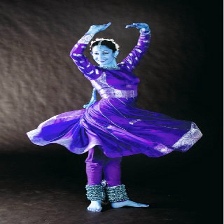

In [14]:
training_data[1]


In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(12,12))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

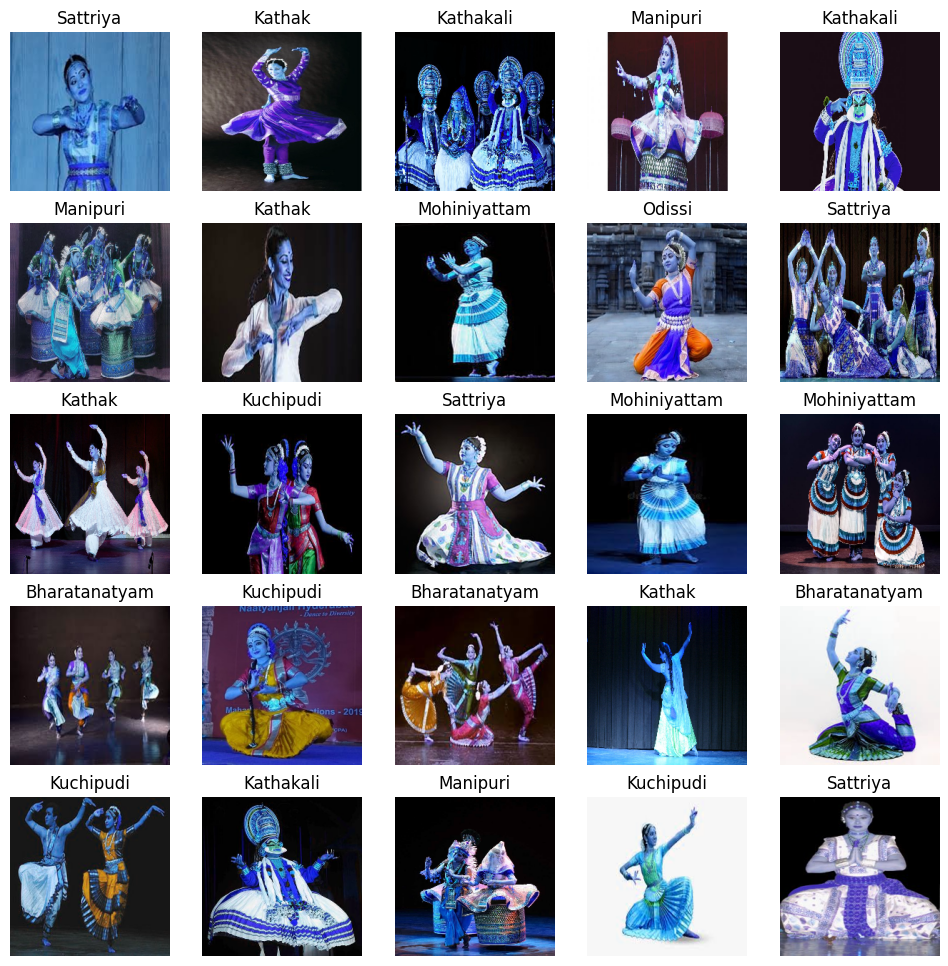

In [16]:
show_batch(training_data, training_labels)


In [17]:
testing_data = test_data_prepare(test_fnames, test_dir)


In [18]:
le =LabelEncoder()
training_labels=le.fit_transform(training_labels)

In [19]:
training_labels[:10]


array([7, 1, 2, 4, 2, 4, 1, 5, 6, 7])

In [20]:
X_train, X_val, y_train, y_val = train_test_split(training_data, training_labels, test_size=0.33, random_state=42)


In [21]:
train_datagenerator = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        rotation_range=40,
        zoom_range = 0.20,
        width_shift_range=0.10,
        height_shift_range=0.10,
        horizontal_flip=True,
        vertical_flip=False)


val_datagenerator=ImageDataGenerator(
        rescale=1. / 255
)

train_datagenerator.fit(X_train)
val_datagenerator.fit(X_val)
X_train=np.array(X_train)
X_val=np.array(X_val)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(243, 224, 224, 3)
(243,)
(121, 224, 224, 3)
(121,)


In [23]:
# traing using transfer learning

vggmodel =VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3),pooling='max')

 # Print the model summary
vggmodel.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
vggmodel.trainable = False
model = Sequential([
  vggmodel,
  Dense(1024, activation='relu'),
  Dropout(0.15),
  Dense(256, activation='relu'),
  Dropout(0.15),
  Dense(8, activation='softmax'),
])

In [25]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [27]:
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history =model.fit(
    train_datagenerator.flow(X_train, to_categorical(y_train,8), batch_size=16),
    validation_data=val_datagenerator.flow(X_val, to_categorical(y_val,8), batch_size=16),
    verbose=2,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
16/16 - 23s - 1s/step - accuracy: 0.1852 - loss: 2.5436 - val_accuracy: 0.2975 - val_loss: 2.0746 - learning_rate: 1.0000e-03
Epoch 2/30
16/16 - 4s - 220ms/step - accuracy: 0.2798 - loss: 1.9650 - val_accuracy: 0.5041 - val_loss: 1.6195 - learning_rate: 1.0000e-03
Epoch 3/30
16/16 - 5s - 293ms/step - accuracy: 0.3045 - loss: 1.7534 - val_accuracy: 0.4215 - val_loss: 1.5446 - learning_rate: 1.0000e-03
Epoch 4/30
16/16 - 4s - 221ms/step - accuracy: 0.4609 - loss: 1.4481 - val_accuracy: 0.5950 - val_loss: 1.3270 - learning_rate: 1.0000e-03
Epoch 5/30
16/16 - 3s - 219ms/step - accuracy: 0.5103 - loss: 1.3064 - val_accuracy: 0.4959 - val_loss: 1.4443 - learning_rate: 1.0000e-03
Epoch 6/30
16/16 - 4s - 258ms/step - accuracy: 0.5350 - loss: 1.3661 - val_accuracy: 0.5041 - val_loss: 1.3095 - learning_rate: 1.0000e-03
Epoch 7/30
16/16 - 5s - 282ms/step - accuracy: 0.5267 - loss: 1.2256 - val_accuracy: 0.3884 - val_loss: 1.6639 - learning_rate: 1.0000e-03
Epoch 8/30
16/16 - 4s - 220ms

In [28]:
history.history['val_accuracy']


[0.2975206673145294,
 0.5041322112083435,
 0.42148759961128235,
 0.5950413346290588,
 0.4958677589893341,
 0.5041322112083435,
 0.38842976093292236,
 0.5785123705863953,
 0.5950413346290588,
 0.6198347210884094,
 0.5041322112083435,
 0.64462810754776,
 0.6280992031097412,
 0.6198347210884094,
 0.6280992031097412,
 0.6363636255264282,
 0.6280992031097412,
 0.6363636255264282,
 0.64462810754776,
 0.6363636255264282,
 0.6280992031097412,
 0.6280992031097412,
 0.6363636255264282,
 0.6280992031097412,
 0.6280992031097412,
 0.6280992031097412,
 0.6363636255264282,
 0.6280992031097412,
 0.6363636255264282,
 0.6363636255264282]

Text(0.5, 1.0, 'Training and validation loss')

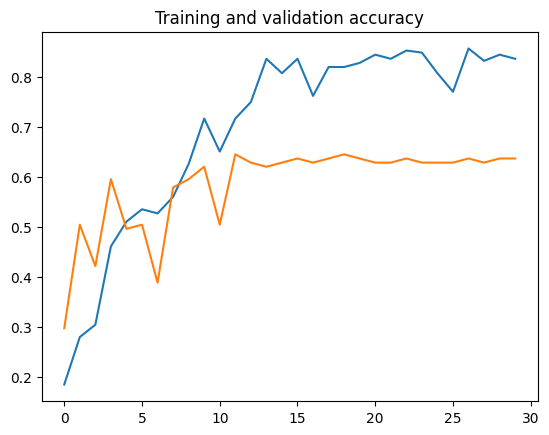

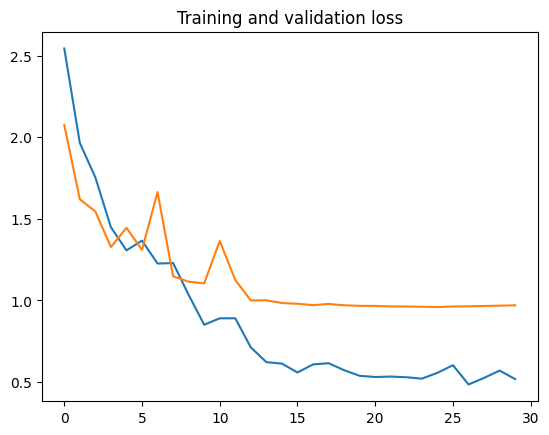

In [29]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc      = history.history['accuracy']
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc )
plt.plot( epochs, val_acc )
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )